# Advanced Certification in AIML
## A Program by IIIT-H and TalentSprint

## Learning Objectives

At the end of the experiment, you will be able to:

* understand  BERT (Bidirectional Encoder Representations from Transformers)  Algorithm implementation
* understand how to preprocess text into an appropriate format


### Dataset Description

The spam and ham dataset have been collected for SMS Spam research. It contains one set of SMS messages in English of 5,574 messages, tagged acording being ham or spam.



In [ ]:
! wget -qq https://cdn.iiith.talentsprint.com/aiml/Experiment_related_data/spam_data.csv
! sx pip install tensorflow_text

**Import the Libraries**

In [ ]:
import numpy as np
import pandas as pd
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Dropout, Activation
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix , classification_report

**Load the Data**

In [ ]:
data = pd.read_csv('/content/spam_data.csv')
data.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### Data Pre-Processing

In [ ]:
# Check count of the unique rows in the DataFrame
data['Category'].value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

As the data is imbalanced and there are more good emails(ham) than spam emails. This may lead to OVERFITTING as a model may learn all the features of the ham emails over spam emails. So, downsample the data before preparing the model.

**Downsampling Data**

Downsampling is a technique where the majority class is downsampled to match the minority class. So, perform downsampling by just picking any random 747 samples from the ham class. 

In [ ]:
# Collect spam and ham datasets

df_spam = data[data['Category']=='spam']
df_ham = data[data['Category']=='ham']

print("Ham Dataset Shape:", df_ham.shape)
print("Spam Dataset Shape:", df_spam.shape)

Ham Dataset Shape: (4825, 2)
Spam Dataset Shape: (747, 2)


In [ ]:
# Downsample ham dataset by taking only random 747 example
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(747, 2)

In [ ]:
# Concatinate both datasets and verify the unique rows count of the class labels
df_balanced = pd.concat([df_spam , df_ham_downsampled])
df_balanced['Category'].value_counts()

ham     747
spam    747
Name: Category, dtype: int64

**LabelEncoder**

LabelEncoder converts the categorical features into numeric values. LabelEncoder encode labels with a value between 0 and n_classes-1, where n is the number of distinct labels

In [ ]:
# Convert the labels into a numeric form using LabelEncoder
label_encoder = preprocessing.LabelEncoder()
df_balanced['Category'] = label_encoder.fit_transform(df_balanced['Category'])
df_balanced['Category'].unique()

array([1, 0])

In [ ]:
# Split the data in a strafied fashion to preserve the same proportions of samples in each class
from sklearn.model_selection import train_test_split
X_train, X_test , y_train, y_test = train_test_split(df_balanced['Message'], df_balanced['Category'], stratify = df_balanced['Category'])
print("Train split by classes\n",y_train.value_counts(),"\n\n", "Test split by classes\n",y_test.value_counts())

Train split by classes
 1    560
0    560
Name: Category, dtype: int64 

 Test split by classes
 1    187
0    187
Name: Category, dtype: int64


### BERT (Bidirectional Encoder Representations from Transformers) 

BERT provides dense vector representations for natural language by using a deep, pre-trained neural network with the Transformer architecture. 

It was originally published by
Jacob Devlin, Ming-Wei Chang, Kenton Lee, Kristina Toutanova: "BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding", 2018.

**Prepare the Model**

1.   Download the bert model and fine-tune the model using Keras Functional API.

     * TensorFlow Hub model uses the implementation of BERT from the TensorFlow Models repository on GitHub at **tensorflow/models/official/nlp/bert**. 
     * It has hidden layers of L = 12(i.e., Transformer blocks), a hidden size of H = 768, and attention heads of A = 12.

2.   text_input: As the model data shape can be anything, so given shape parameters as shape() and data type as tf. string

3.   Preprocess the Text inputs and transform to numeric token ids before being input to BERT.

4.  Pass through the Bert model and it returns pooled output. 
    * pooled_output represents each input sequence as a whole. The shape is [batch_size, Hidden size]. 

5.   Dropout: Set dropout rate 0.1, which means 10% of neurons will randomly shut off and pass embedding dictionary pooled_output as an input to this layer.


In [ ]:
# Downloading preprocessing files and model from the TF models repository. This will take more time for dowloading the files
preprocessing_layer = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')
bert_encoder = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4')

In [ ]:
def build_classifier_model():
  text_input = keras.layers.Input(shape=(), dtype=tf.string, name='text')
  # Preprocess the text inputs
  encoder_inputs = preprocessing_layer(text_input)
  # Pass through the bert model
  outputs = bert_encoder(encoder_inputs)
  # Model returns embedding of the entire dataset
  net = outputs['pooled_output']
  # Pass the entire training data embeddings to the dropout layer.
  net = keras.layers.Dropout(0.1)(net)
  # Dense Layer
  net = keras.layers.Dense(1, activation='sigmoid', name='classifier')(net)
  results = keras.Model(text_input, net)
  return results


In [ ]:
model = build_classifier_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None,)]            0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        {'input_type_ids': ( 0           text[0][0]                       
__________________________________________________________________________________________________
keras_layer_1 (KerasLayer)      {'pooled_output': (N 109482241   keras_layer[0][0]                
                                                                 keras_layer[0][1]                
                                                                 keras_layer[0][2]                
______________________________________________________________________________________________

In [ ]:
# Compiling the model
metrics = tf.keras.metrics.BinaryAccuracy()
model.compile(optimizer ='adam', loss = 'binary_crossentropy', metrics = metrics)

### Train and Evaluate the model


In [ ]:
# This will take more time for execution.
history = model.fit(X_train, y_train, epochs = 5)

Epoch 1/5
35/35 [==============================] - 32s 573ms/step - loss: 0.6644 - binary_accuracy: 0.5893
Epoch 2/5
35/35 [==============================] - 20s 575ms/step - loss: 0.5322 - binary_accuracy: 0.7616
Epoch 3/5
35/35 [==============================] - 20s 578ms/step - loss: 0.4490 - binary_accuracy: 0.8446
Epoch 4/5
35/35 [==============================] - 20s 581ms/step - loss: 0.4029 - binary_accuracy: 0.8768
Epoch 5/5
35/35 [==============================] - 20s 586ms/step - loss: 0.3732 - binary_accuracy: 0.8830


In [ ]:
# Evaluate the performance with the test data
model.evaluate(X_test,y_test)

12/12 [==============================] - 8s 568ms/step - loss: 0.3988 - binary_accuracy: 0.8449


[0.3987634778022766, 0.8449198007583618]

### Plotting Confusion Matrix and Classification Reports

In [ ]:
# Get the predictions and flatten them
y_pred = model.predict(X_test)
y_pred = y_pred.flatten() # require to be in one-dimensional array
y_pred = y_pred > 0.5 # to get the probability

Text(33.0, 0.5, 'Actual')

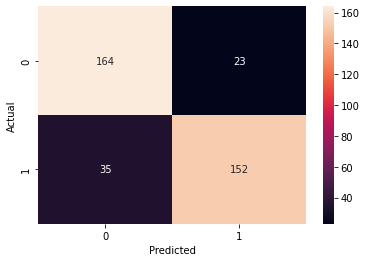

In [ ]:
# Creating Confusion Matrix 
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat, annot = True, fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [ ]:
# Classification Report
print(classification_report(y_test , y_pred))

              precision    recall  f1-score   support

           0       0.82      0.88      0.85       187
           1       0.87      0.81      0.84       187

    accuracy                           0.84       374
   macro avg       0.85      0.84      0.84       374
weighted avg       0.85      0.84      0.84       374



### Model Prediction on set of samples

1. Create a list that contains a collection of few spam and ham emails
2. Predict the sentence category using our model and store the result in variable ‘test_result‘.
3. Create a lambda function for filtering values greater than ‘as spam’ else, not ‘spam’ using NumPy. 


In [ ]:
predict_text = [
                # Spam
                'We’d all like to get a $10,000 deposit on our bank accounts out of the blue, but winning a prize—especially if you’ve never entered a contest', 
                'Netflix is sending you a refund of $12.99. Please reply with your bank account and routing number to verify and get your refund', 
                'Your account is temporarily frozen. Please log in to to secure your account ', 
                # Ham
                'The article was published on 18th August itself',
                'Although we are unable to give you an exact time-frame at the moment, I would request you to stay tuned for any updates.',
                'The image you sent is a UI bug, I can check that your article is marked as regular and is not in the monetization program.'
]

In [ ]:
test_results = model.predict(predict_text)
output = np.where(test_results > 0.5,'spam', 'ham')
output

array([['spam'],
       ['spam'],
       ['spam'],
       ['ham'],
       ['ham'],
       ['ham']], dtype='<U4')